# ICR - Identifying Age-Related Conditions Dataset with TensorFlow Decision Forests

The goal of this modeling is to predict if a person has one or more of any of three medical conditions or none.

Rough breakdown of notebook contents:

1. Import libraries
2. Load Data
3. Data cleaning and preprocessing
4. Modeling

### Summary of Modeling Choices

<table>
  <tr>
    <th style="text-align:left;">Choice</th>
    <th style="text-align:left;">Details</th>
  </tr>
  <tr>
    <td style="text-align:left;">Data Preprocessing</td>
    <td style="text-align:left;">training only (no greeks)</td>
  </tr>
  <tr>
    <td style="text-align:left;">Split</td>
    <td style="text-align:left;">random 80-20 (no time dependency)</td>
  </tr>
  <tr>
    <td style="text-align:left;">Class Imbalance Mitigation</td>
    <td style="text-align:left;">downsampling</td>
  </tr>
  <tr>
    <td style="text-align:left;">Feature Normalization</td>
    <td style="text-align:left;">Standard Scalar</td>
  </tr>
  <tr>
    <td style="text-align:left;">Metric</td>
    <td style="text-align:left;">ROC-AUC</td>
  </tr>
  <tr>
    <td style="text-align:left;">Loss</td>
    <td style="text-align:left;">Binary Crossentropy + Log Loss on Test</td>
  </tr>
</table>

#### Kaggle Competition Performance Metric:

$$\log \text { Loss }=\frac{-\frac{1}{N_0} \sum_{i=1}^{N_0} y_{0 i} \log p_{0 i}-\frac{1}{N_1} \sum_{i=1}^{N_1} y_{1 i} \log p_{1 i}}{2}$$

# 1. Import Libraries

In [119]:
import tensorflow as tf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from keras import metrics
from tensorflow import keras

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

from mlxtend.plotting import scatterplotmatrix
from mlxtend.plotting import heatmap

#improve figure resolution
%matplotlib inline 
%config InlineBackend.figure_format = 'retina'


pd.set_option('display.max_columns', None) #show all columns
pd.set_option('display.max_rows', None) #show all rows

In [120]:
print("TensorFlow v" + tf.__version__)

TensorFlow v2.12.0


# 2. Load Data

In [121]:
data = pd.read_csv('../icr-identify-age-related-conditions/train.csv')
print("Full train dataset shape is {}".format(data.shape))

Full train dataset shape is (617, 58)


The data is composed of 58 columns and 617 entries. We can see all 58 dimensions(results will be truncated since the number of columns is big) of our dataset by printing out the first 5 entries using the following code:

In [122]:
data.head()

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,BN,BP,BQ,BR,BZ,CB,CC,CD,CF,CH,CL,CR,CS,CU,CW,DA,DE,DF,DH,DI,DL,DN,DU,DV,DY,EB,EE,EG,EH,EJ,EL,EP,EU,FC,FD,FE,FI,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class
0,000ff2bfdfe9,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,4126.58731,22.5984,175.638726,152.707705,823.928241,257.432377,47.223358,0.563481,23.387600,4.851915,0.023482,1.050225,0.069225,13.784111,1.302012,36.205956,69.08340,295.570575,0.23868,0.284232,89.245560,84.31664,29.657104,5.310690,1.74307,23.187704,7.294176,1.987283,1433.166750,0.949104,B,30.879420,78.526968,3.828384,13.394640,10.265073,9028.291921,3.583450,7.298162,1.73855,0.094822,11.339138,72.611063,2003.810319,22.136229,69.834944,0.120343,1
1,007255e47698,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,5496.92824,19.4205,155.868030,14.754720,51.216883,257.432377,30.284345,0.484710,50.628208,6.085041,0.031442,1.113875,1.117800,28.310953,1.357182,37.476568,70.79836,178.553100,0.23868,0.363489,110.581815,75.74548,37.532000,0.005518,1.74307,17.222328,4.926396,0.858603,1111.287150,0.003042,A,109.125159,95.415086,52.260480,17.175984,0.296850,6785.003474,10.358927,0.173229,0.49706,0.568932,9.292698,72.611063,27981.562750,29.135430,32.131996,21.978000,0
2,013f2bd269f5,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,5135.78024,26.4825,128.988531,219.320160,482.141594,257.432377,32.563713,0.495852,85.955376,5.376488,0.036218,1.050225,0.700350,39.364743,1.009611,21.459644,70.81970,321.426625,0.23868,0.210441,120.056438,65.46984,28.053464,1.289739,1.74307,36.861352,7.813674,8.146651,1494.076488,0.377208,B,109.125159,78.526968,5.390628,224.207424,8.745201,8338.906181,11.626917,7.709560,0.97556,1.198821,37.077772,88.609437,13676.957810,28.022851,35.192676,0.196941,0
3,043ac50845d5,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,4169.67738,23.6577,237.282264,11.050410,661.518640,257.432377,15.201914,0.717882,88.159360,2.347652,0.029054,1.400300,0.636075,41.116960,0.722727,21.530392,47.27586,196.607985,0.23868,0.292431,139.824570,71.57120,24.354856,2.655345,1.74307,52.003884,7.386060,3.813326,15691.552180,0.614484,B,31.674357,78.526968,31.323372,59.301984,7.884336,10965.766040,14.852022,6.122162,0.49706,0.284466,18.529584,82.416803,2094.262452,39.948656,90.493248,0.155829,0
4,044fb8a146ec,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,5728.73412,24.0108,324.546318,149.717165,6074.859475,257.432377,82.213495,0.536467,72.644264,30.537722,0.025472,1.050225,0.693150,31.724726,0.827550,34.415360,74.06532,200.178160,0.23868,0.207708,97.920120,52.83888,26.019912,1.144902,1.74307,9.064856,7.350720,3.490846,1403.656300,0.164268,B,109.125159,91.994825,51.141336,29.102640,4.274640,16198.049590,13.666727,8.153058,48.50134,0.121914,16.408728,146.109943,8524.370502,45.381316,36.262628,0.096614,1


`Class` is the label column indicating if a person has one or more of any of the three medical conditions (i.e,`Class 1`), or none of the three medical conditions (i.e,`Class 0`).
Given the features of the dataset, the goal of our model is to predict the value of `Class` for any person.

# 3. Data Preprocessing

### Transform and Split Data

In [123]:
#convert ej column to one-hot encoding 

ej_dummy = pd.get_dummies(
    data['EJ'],prefix='EJ', dtype=int
)

with_dummies_df = pd.concat(
    [data,ej_dummy],
    axis=1
)

data = with_dummies_df.drop(['EJ'], axis=1)
data.columns

Index(['Id', 'AB', 'AF', 'AH', 'AM', 'AR', 'AX', 'AY', 'AZ', 'BC', 'BD ', 'BN',
       'BP', 'BQ', 'BR', 'BZ', 'CB', 'CC', 'CD ', 'CF', 'CH', 'CL', 'CR', 'CS',
       'CU', 'CW ', 'DA', 'DE', 'DF', 'DH', 'DI', 'DL', 'DN', 'DU', 'DV', 'DY',
       'EB', 'EE', 'EG', 'EH', 'EL', 'EP', 'EU', 'FC', 'FD ', 'FE', 'FI', 'FL',
       'FR', 'FS', 'GB', 'GE', 'GF', 'GH', 'GI', 'GL', 'Class', 'EJ_A',
       'EJ_B'],
      dtype='object')

In [124]:
#split data on a random 80-20 split
train, test = train_test_split(data, test_size=0.2, random_state = 1234)

## Training Preprocessing

### Dealing with Class Imbalance

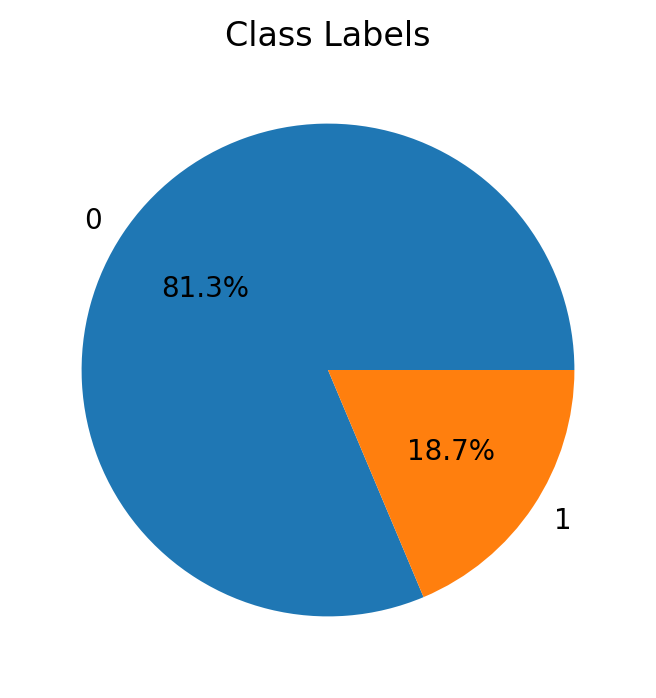

In [125]:
dist = train['Class'].value_counts()

plt.figure(figsize=(4, 4))
plt.pie(dist, labels=[0,1], autopct='%1.1f%%')
plt.title('Class Labels')
plt.show()

#### Downsampling

*Removed step in favor of using class weights*

In [126]:
# Separate majority and minority classes
majority_class = train[train['Class'] == 0]
minority_class = train[train['Class'] == 1]

# Downsample the majority class to match the size of the minority class
downsampled_majority = resample(majority_class,
                                replace=False,     # Without replacement
                                n_samples=len(minority_class),  # Match minority class size
                                random_state=42)   # For reproducibility

# Combine the downsampled majority class with the minority class
train = pd.concat([downsampled_majority, minority_class])

# Shuffle the data to avoid any order bias
train = train.sample(frac=1, random_state=42)

### Missing Data

In [127]:
train_summary = train.describe().transpose()
train_summary.head()

,count,mean,std,min,25%,50%,75%,max
AB,184.0,0.602981,0.675666,0.098279,0.282018,0.418754,0.682078,6.161666
AF,184.0,4116.521055,2962.048518,192.593280,2495.266840,3730.342880,4979.977035,28688.187660
AH,184.0,118.145892,113.515872,85.200147,85.200147,85.200147,106.413094,1237.940805
AM,184.0,57.355741,109.194252,5.562212,14.261685,24.212346,44.788814,630.518230
AR,184.0,10.206833,5.781580,8.138688,8.138688,8.138688,8.138688,50.253252


We have 9 columns with missing data, as can be seen below. The columns with the most missing data are BQ and EL, each with 60 null values. Since 60 null values amounts to only about 10% of the dataset, it is reasonable to use imputation to fill the missing values.

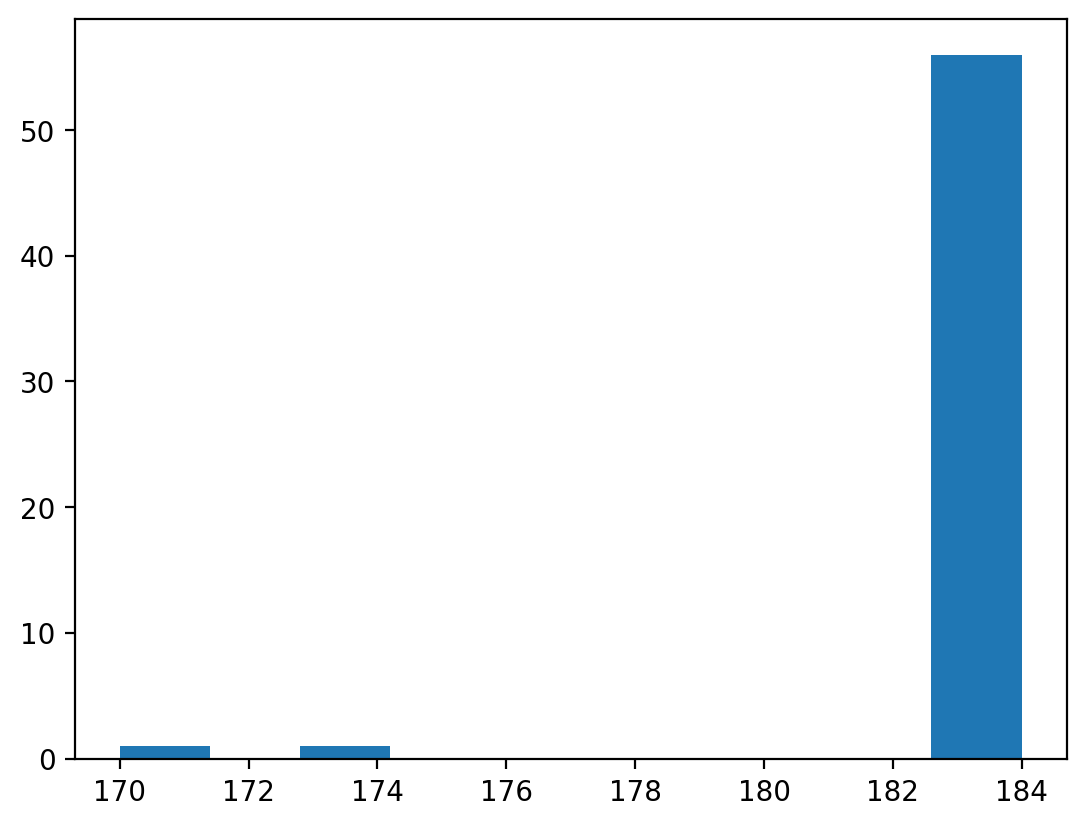

Summary of Columns with Missing Data:


,count,mean,std,min,25%,50%,75%,max
AB,184.0,0.602981,0.675666,0.098279,0.282018,0.418754,0.682078,6.161666
AF,184.0,4116.521055,2962.048518,192.593280,2495.266840,3730.342880,4979.977035,28688.187660
AH,184.0,118.145892,113.515872,85.200147,85.200147,85.200147,106.413094,1237.940805
AM,184.0,57.355741,109.194252,5.562212,14.261685,24.212346,44.788814,630.518230
AR,184.0,10.206833,5.781580,8.138688,8.138688,8.138688,8.138688,50.253252
AX,184.0,5.690704,3.310532,0.699861,4.194737,5.062919,6.283246,38.270880
AY,184.0,0.095911,0.759223,0.025578,0.025578,0.025578,0.031592,10.315851
AZ,184.0,10.475705,3.759717,3.396778,8.630589,10.577907,12.725314,23.626198
BC,184.0,17.896554,118.654008,1.229900,1.229900,1.229900,5.961501,1463.693448
BD,184.0,5865.621015,4994.313646,2298.699030,4303.034475,5039.932200,6217.246715,53060.599240


In [128]:
plt.hist(train_summary['count'])
plt.show()
print("Summary of Columns with Missing Data:")
train_summary.loc[train_summary['count'] < 493]

Start with simple imputation which will fill missing values with the mean of the other values recorded for that feature. Note that iterative imputation is also possible through sk learn: https://scikit-learn.org/stable/modules/generated/sklearn.impute.IterativeImputer.html#sklearn.impute.IterativeImputer

In [129]:
# Identify continuous variables (assuming they are numeric)
continuous_vars = train.select_dtypes(include='number').columns

# Perform mean imputation for continuous variables
train[continuous_vars] = train[continuous_vars].fillna(train[continuous_vars].mean())


In [130]:
# Check which columns still have missing values 
sum_null = train.isnull().sum()
sum_null[sum_null!=0]

Series([], dtype: int64)

### Split Training Set into X and Y

In [131]:
columns = train.columns.drop(['Id','Class'])
columns

Index(['AB', 'AF', 'AH', 'AM', 'AR', 'AX', 'AY', 'AZ', 'BC', 'BD ', 'BN', 'BP',
       'BQ', 'BR', 'BZ', 'CB', 'CC', 'CD ', 'CF', 'CH', 'CL', 'CR', 'CS', 'CU',
       'CW ', 'DA', 'DE', 'DF', 'DH', 'DI', 'DL', 'DN', 'DU', 'DV', 'DY', 'EB',
       'EE', 'EG', 'EH', 'EL', 'EP', 'EU', 'FC', 'FD ', 'FE', 'FI', 'FL', 'FR',
       'FS', 'GB', 'GE', 'GF', 'GH', 'GI', 'GL', 'EJ_A', 'EJ_B'],
      dtype='object')

In [132]:
# save x_train, y_train, X_test and Y_test as Numpy arrays
y_train = train['Class'].values
# y_test = test['Class'].values

X_train = train[columns].values
# X_test = test[columns].values


# # Check the shape of the train and test sets
# print('Shape X_train: ', X_train.shape, '\nShape X_test: ', X_test.shape,
#       '\nShape y_train: ', y_train.shape, '\nShape y_test:', y_test.shape)
    
print('Shape X_train: ', X_train.shape,
      '\nShape y_train: ', y_train.shape)

Shape X_train:  (184, 57) 
Shape y_train:  (184,)


### Standardize values between 0 and 1

In [133]:
#normalize all values to be between 0 and 1
# X_train = (X_train-np.min(X_train))/(np.max(X_train)-np.min(X_train))

# #view normalized array
# print(X_train)

### Standard Scalar

In [134]:
# standardize features
sc = StandardScaler()

X_train = sc.fit(X_train).transform(X_train)
# X_test = sc.fit(X_train).transform(X_test)

# 4. Model

Based on Juliana's analysis using Random Forest, we will start by focusing on the following features, in order of importance: 

**Suggested features for input:** DU, AB, BQ, GL, CR, DA, DI, AF, CC, EE, FR, DE, EB, DL, CD, FE, DH, BC, FI, EU, BN, BP, CU, CB, DY, FC, DN, AM, EG, CS, GH, CF, GF, BD, GI


#### Model with Specified Input Features

An alternative, more flexible option is to use logistic regression, creating an architecutre with a single dense layer and a sigmoid activation function. Logistic regression is very similar to a perceptron but allows us to predict probabilities of binary outcomes as opposed to just a -1 / 1 outcome.

In [135]:
#create a new array with selected features
feature_list = ['DU', 'AB','BQ','GL','CR','DA','DI','AF','CC','EE','FR',
                'DE','EB','DL','CD ','FE','DH','BC','FI','EU','BN', 'BP',
                'CU', 'CB', 'DY', 'FC', 'DN', 'AM','EG','CS','GH','CF','GF',
                'BD ','GI']
columns = list(columns)
X_limited_train = np.array([])

for feature in feature_list:
    feature_index = columns.index(feature)
    feature_array = X_train[:, feature_index]
    
    if X_limited_train.size == 0:
        X_limited_train = feature_array
    else:
        X_limited_train = np.column_stack((X_limited_train, feature_array))

In [136]:
def perceptron_tfmodel(num_features, 
                       activation = 'sigmoid', 
                       learning_rate = 0.001, 
                       optimizer = 'SGD'
                       ):
    
    #clear session and set random seed for consistent behavior
    tf.keras.backend.clear_session()
    tf.random.set_seed(1234)
    
    #Build model using Keras Sequential API
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(1, activation = activation, input_shape = (num_features,))
    ])
    
    #set up optimizer
    sgd_optimizer = tf.keras.optimizers.SGD(learning_rate = learning_rate)
    adam_optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)
    if optimizer == 'Adam':
        optimizer = adam_optimizer
    else:
        optimizer = sgd_optimizer
    
    #compile model
    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy',  # Binary cross-entropy loss for binary classification
                  metrics=['accuracy', tf.keras.metrics.AUC(name='prc', curve='PR')])
    
    return model

In [137]:
model = perceptron_tfmodel(num_features = X_limited_train.shape[1], learning_rate = 0.1)

In [138]:
#Fit the model
tf.random.set_seed(1234)
np.random.seed(1234)
# Train model
hist= model.fit(x=X_limited_train,
                y=y_train,
                validation_split=0.2, # set 20% of train data for validation
                batch_size= 30, #choose smaller batch size bc we're guessing there are local optima 
                epochs=50,
                verbose=1 #silence fit
                # class_weight = {0: 1.0, 1: 5.0}
)

Epoch 1/50
1/5 [=====>........................] - ETA: 1s - loss: 1.0838 - accuracy: 0.4667 - prc: 0.5505

2023-08-10 09:05:04.791426: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


5/5 [==============================] - 1s 99ms/step - loss: 0.8981 - accuracy: 0.5238 - prc: 0.5359 - val_loss: 0.6354 - val_accuracy: 0.7027 - val_prc: 0.8610
Epoch 2/50
1/5 [=====>........................] - ETA: 0s - loss: 0.8861 - accuracy: 0.6333 - prc: 0.6396

2023-08-10 09:05:05.180651: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


5/5 [==============================] - 0s 24ms/step - loss: 0.7470 - accuracy: 0.5850 - prc: 0.6345 - val_loss: 0.5708 - val_accuracy: 0.7297 - val_prc: 0.8999
Epoch 3/50
5/5 [==============================] - 0s 21ms/step - loss: 0.6481 - accuracy: 0.6667 - prc: 0.7080 - val_loss: 0.5245 - val_accuracy: 0.7568 - val_prc: 0.9121
Epoch 4/50
5/5 [==============================] - 0s 27ms/step - loss: 0.5792 - accuracy: 0.6939 - prc: 0.7639 - val_loss: 0.4903 - val_accuracy: 0.7838 - val_prc: 0.9223
Epoch 5/50
5/5 [==============================] - 0s 31ms/step - loss: 0.5278 - accuracy: 0.7143 - prc: 0.8156 - val_loss: 0.4631 - val_accuracy: 0.8108 - val_prc: 0.9338
Epoch 6/50
5/5 [==============================] - 0s 22ms/step - loss: 0.4917 - accuracy: 0.7415 - prc: 0.8434 - val_loss: 0.4415 - val_accuracy: 0.8108 - val_prc: 0.9374
Epoch 7/50
5/5 [==============================] - 0s 22ms/step - loss: 0.4606 - accuracy: 0.7551 - prc: 0.8728 - val_loss: 0.4239 - val_accuracy: 0.8108 - v

Epoch 50/50
5/5 [==============================] - 0s 19ms/step - loss: 0.2698 - accuracy: 0.9048 - prc: 0.9662 - val_loss: 0.2625 - val_accuracy: 0.8378 - val_prc: 0.9848


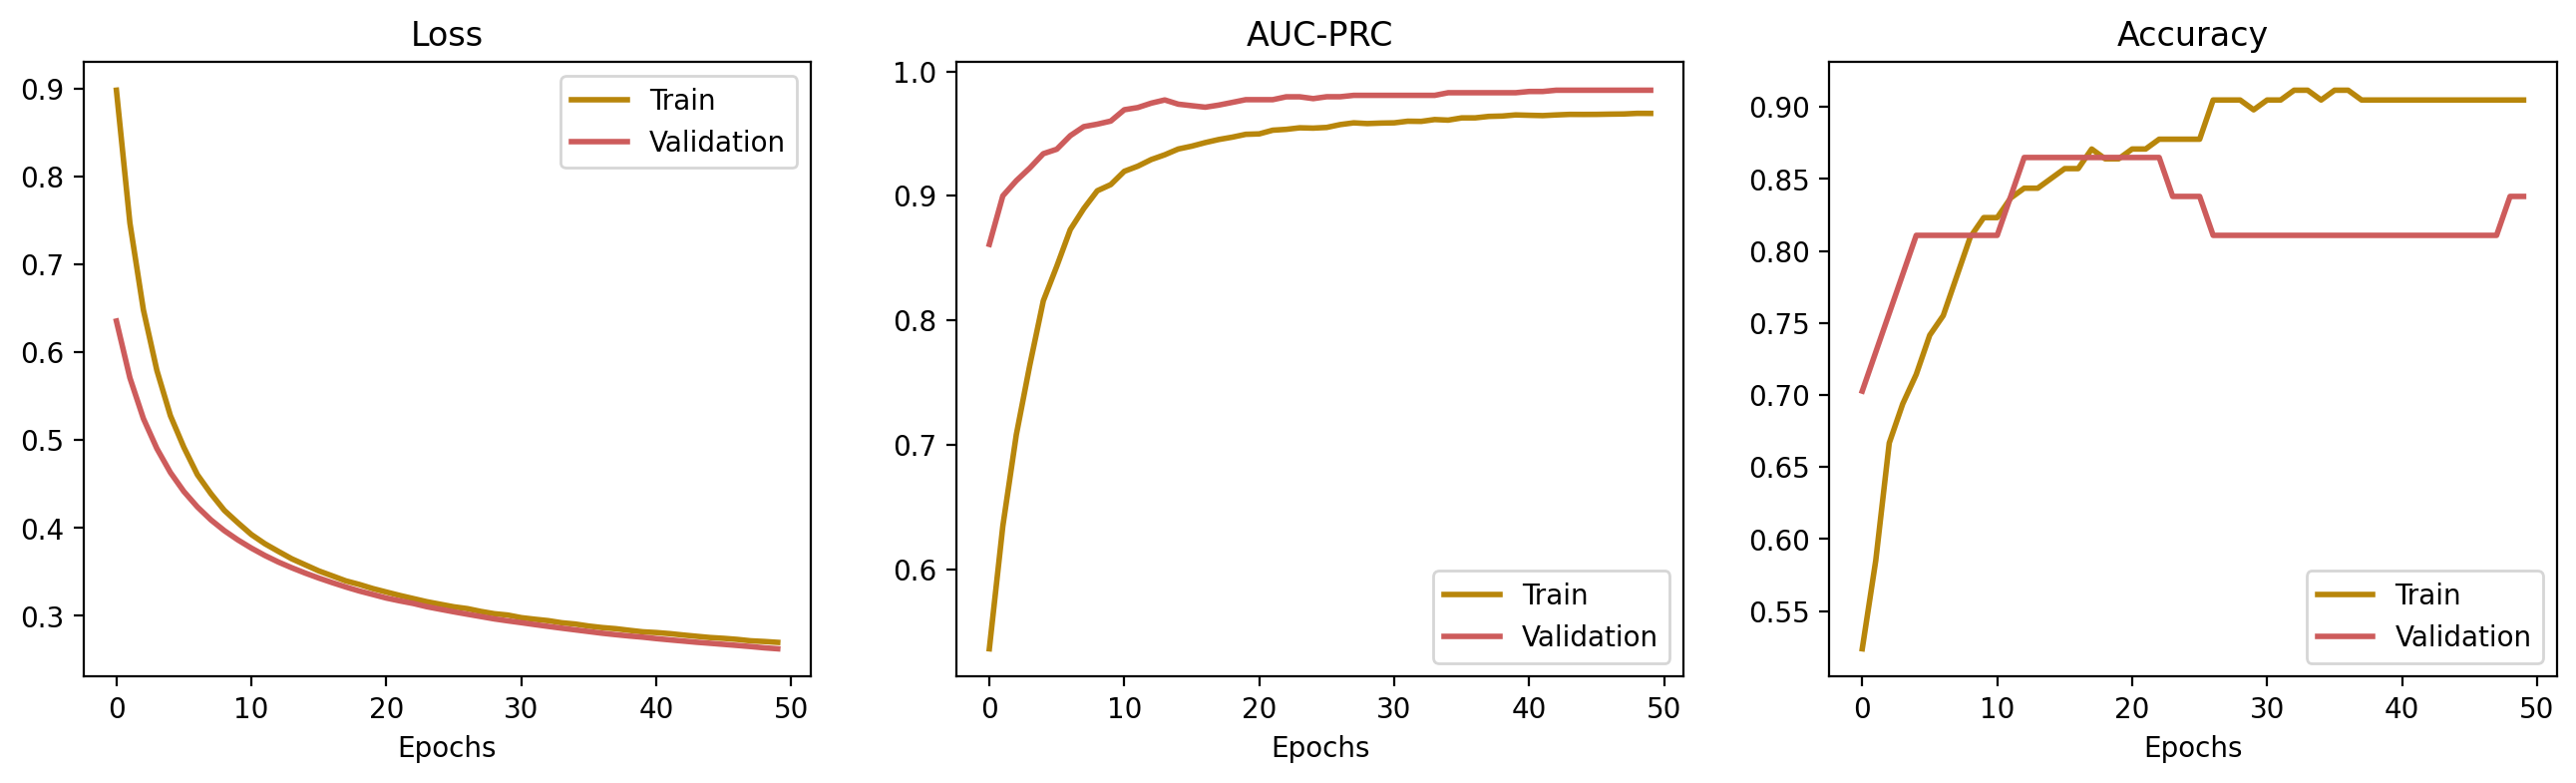


Baseline:          0.5000
Train Accuracy:     0.9048
AUC-PRC:           0.9662


In [139]:
# grab history
history = hist.history

# plot loss for train and validation
fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 3, 1)
plt.plot(history['loss'], lw=2, color='darkgoldenrod')
plt.plot(history['val_loss'], lw=2, color='indianred')
plt.legend(['Train', 'Validation'], fontsize=10)
ax.set_xlabel('Epochs', size=10)
ax.set_title('Loss');

# plot accuracy for train and validation
ax = fig.add_subplot(1, 3, 2)
plt.plot(history['prc'], lw=2, color='darkgoldenrod')
plt.plot(history['val_prc'], lw=2, color='indianred')
plt.legend(['Train', 'Validation'], fontsize=10)
ax.set_xlabel('Epochs', size=10)
ax.set_title('AUC-PRC');

# plot accuracy for train and validation
ax = fig.add_subplot(1, 3, 3)
plt.plot(history['accuracy'], lw=2, color='darkgoldenrod')
plt.plot(history['val_accuracy'], lw=2, color='indianred')
plt.legend(['Train', 'Validation'], fontsize=10)
ax.set_xlabel('Epochs', size=10)
ax.set_title('Accuracy');

plt.show()

print('\nBaseline:          %1.4f' %(np.count_nonzero(y_train == 0)/len(y_train)))
print('Train Accuracy:     %1.4f' %(history['accuracy'][-1]))
print('AUC-PRC:           %1.4f' %(history['prc'][-1]))

#### Model with all input features

In [140]:
model = perceptron_tfmodel(num_features = X_train.shape[1], learning_rate = 0.1)

In [141]:
#Fit the model
tf.random.set_seed(1234)
np.random.seed(1234)
# Train model
hist= model.fit(x=X_train,
                y=y_train,
                validation_split=0.2, # set 20% of train data for validation
                batch_size= 30, #choose smaller batch size bc we're guessing there are local optima 
                epochs=50,
                verbose=1 #silence fit
#                 class_weight = {0: 1.0, 1: 5.0}
)

Epoch 1/50
1/5 [=====>........................] - ETA: 1s - loss: 0.6685 - accuracy: 0.6667 - prc: 0.6760

2023-08-10 09:05:10.609090: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


5/5 [==============================] - 1s 100ms/step - loss: 0.8476 - accuracy: 0.5646 - prc: 0.5702 - val_loss: 0.7343 - val_accuracy: 0.6757 - val_prc: 0.7370
Epoch 2/50


2023-08-10 09:05:10.982088: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


5/5 [==============================] - 0s 23ms/step - loss: 0.6656 - accuracy: 0.6531 - prc: 0.7027 - val_loss: 0.6410 - val_accuracy: 0.6757 - val_prc: 0.8063
Epoch 3/50
5/5 [==============================] - 0s 23ms/step - loss: 0.5696 - accuracy: 0.7347 - prc: 0.7902 - val_loss: 0.5793 - val_accuracy: 0.7027 - val_prc: 0.8409
Epoch 4/50
5/5 [==============================] - 0s 22ms/step - loss: 0.5098 - accuracy: 0.7687 - prc: 0.8337 - val_loss: 0.5351 - val_accuracy: 0.7027 - val_prc: 0.8670
Epoch 5/50
5/5 [==============================] - 0s 21ms/step - loss: 0.4660 - accuracy: 0.7959 - prc: 0.8650 - val_loss: 0.5005 - val_accuracy: 0.7027 - val_prc: 0.8885
Epoch 6/50
5/5 [==============================] - 0s 21ms/step - loss: 0.4358 - accuracy: 0.8231 - prc: 0.8873 - val_loss: 0.4729 - val_accuracy: 0.7297 - val_prc: 0.8975
Epoch 7/50
5/5 [==============================] - 0s 21ms/step - loss: 0.4102 - accuracy: 0.8435 - prc: 0.9046 - val_loss: 0.4495 - val_accuracy: 0.7027 - v

Epoch 50/50
5/5 [==============================] - 0s 19ms/step - loss: 0.2351 - accuracy: 0.9252 - prc: 0.9762 - val_loss: 0.2589 - val_accuracy: 0.8919 - val_prc: 0.9939


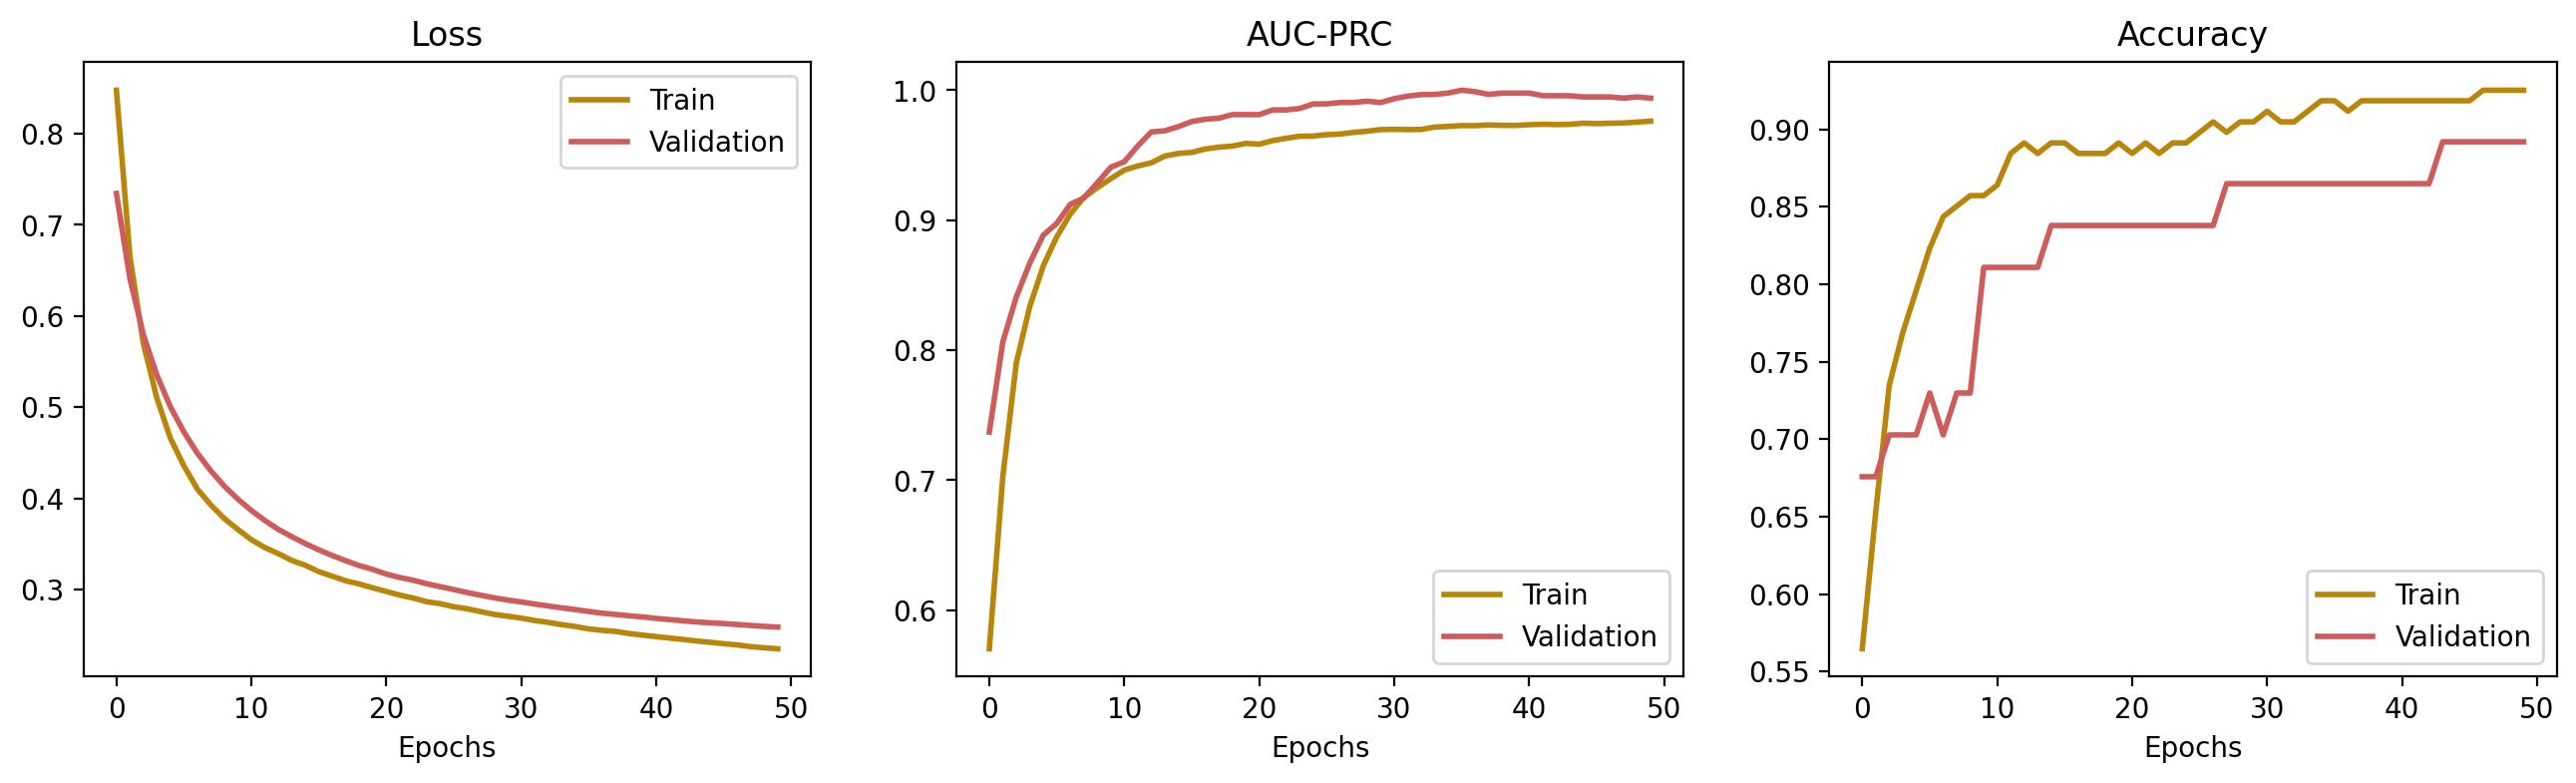


Baseline:          0.5000
Train Accuracy:     0.9252
AUC-PRC:           0.9762


In [142]:
# grab history
history = hist.history

# plot loss for train and validation
fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 3, 1)
plt.plot(history['loss'], lw=2, color='darkgoldenrod')
plt.plot(history['val_loss'], lw=2, color='indianred')
plt.legend(['Train', 'Validation'], fontsize=10)
ax.set_xlabel('Epochs', size=10)
ax.set_title('Loss');

# plot accuracy for train and validation
ax = fig.add_subplot(1, 3, 2)
plt.plot(history['prc'], lw=2, color='darkgoldenrod')
plt.plot(history['val_prc'], lw=2, color='indianred')
plt.legend(['Train', 'Validation'], fontsize=10)
ax.set_xlabel('Epochs', size=10)
ax.set_title('AUC-PRC');

# plot accuracy for train and validation
ax = fig.add_subplot(1, 3, 3)
plt.plot(history['accuracy'], lw=2, color='darkgoldenrod')
plt.plot(history['val_accuracy'], lw=2, color='indianred')
plt.legend(['Train', 'Validation'], fontsize=10)
ax.set_xlabel('Epochs', size=10)
ax.set_title('Accuracy');

plt.show()

print('\nBaseline:          %1.4f' %(np.count_nonzero(y_train == 0)/len(y_train)))
print('Train Accuracy:     %1.4f' %(history['accuracy'][-1]))
print('AUC-PRC:           %1.4f' %(history['prc'][-1]))

**Conclusion:** Logistic regression is far better than the basic perceptron. The full number of features provides marginally better performance.

# Test

### Test Preprocessing

In [143]:
def balanced_log_loss(y_true, y_pred):
    N0 = np.sum(y_true == 0) #num observations class 0
    N1 = np.sum(y_true == 1) #num observations class 1

    p0 = y_pred[y_true == 0] #pred_prob class 0
    p1 = y_pred[y_true == 1] #pred_prob class 0

    y0 = y_true[y_true == 0] #ground truth class 0
    y1 = y_true[y_true == 1] #ground truth class 1

    log_loss_0 = np.sum(y0 * np.log(np.clip(p0, 1e-15, 1.0))) / N0 if N0 > 0 else 0 #balanced log loss class 0, adjust for edge cases (removed the negative sign to avoid negative log loss)
    log_loss_1 = np.sum(y1 * np.log(np.clip(p1, 1e-15, 1.0))) / N1 if N1 > 0 else 0 #balanced log loss class 1, adjust for edge cases 

    return (log_loss_0 + log_loss_1) / 2

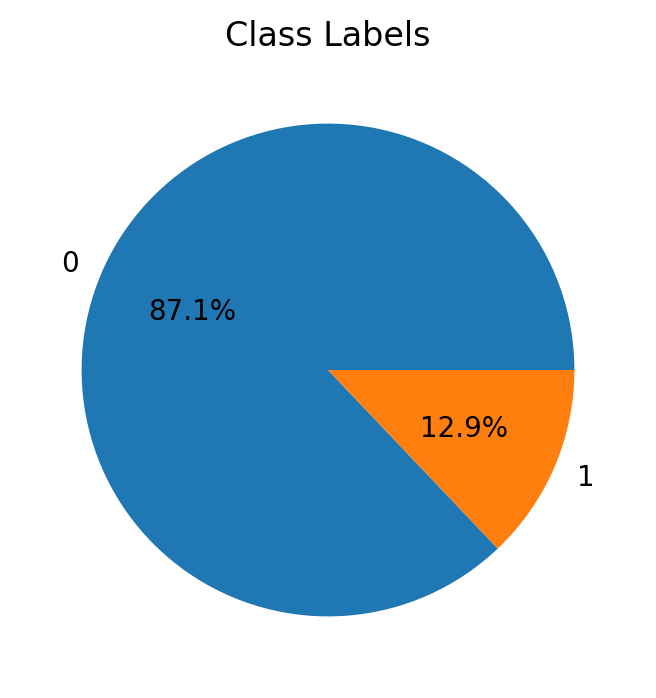

In [145]:
dist = test['Class'].value_counts()

plt.figure(figsize=(4, 4))
plt.pie(dist, labels=[0,1], autopct='%1.1f%%')
plt.title('Class Labels')
plt.show()

In [146]:
test_summary = test.describe().transpose()
test_summary.head()

,count,mean,std,min,25%,50%,75%,max
AB,124.0,0.471856,0.425713,0.085460,0.272404,0.371751,0.548012,4.277273
AF,124.0,3498.343169,2443.976416,192.593280,1904.585073,2938.594505,4449.890252,18720.829600
AH,124.0,111.119255,42.611482,85.200147,85.200147,85.200147,128.760388,292.021479
AM,124.0,37.194645,60.261192,4.803447,14.037927,22.434668,47.651216,630.518230
AR,124.0,9.943216,5.802178,8.138688,8.138688,8.138688,8.293386,59.390922


In [147]:
# Identify continuous variables (assuming they are numeric)
continuous_vars = test.select_dtypes(include='number').columns

# Perform mean imputation for continuous variables
test[continuous_vars] = test[continuous_vars].fillna(test[continuous_vars].mean())

In [148]:
# save X_test and Y_test as Numpy arrays

y_test = test['Class'].values
X_test = test[columns].values

# Check the shape of the test sets
    
print('Shape X_test: ', X_test.shape,
      '\nShape y_test: ', y_test.shape)

Shape X_test:  (124, 57) 
Shape y_test:  (124,)


In [149]:
# standardize features
sc = StandardScaler()

X_test = sc.fit(X_test).transform(X_test)

In [150]:
#limit the features

X_limited_test = np.array([])

for feature in feature_list:
    feature_index = columns.index(feature)
    feature_array = X_test[:, feature_index]
    
    if X_limited_test.size == 0:
        X_limited_test = feature_array
    else:
        X_limited_test = np.column_stack((X_limited_test, feature_array))

### Train the Chosen Model

In [151]:
model = perceptron_tfmodel(num_features = X_train.shape[1], learning_rate = 0.1)

In [152]:
#Fit the model
tf.random.set_seed(1234)
np.random.seed(1234)
# Train model
hist= model.fit(x=X_train,
                y=y_train,
                validation_split=0.2, # set 20% of train data for validation
                batch_size= 30, #choose smaller batch size bc we're guessing there are local optima 
                epochs=50,
                verbose=1, #silence fit
                 class_weight = {0: 1.0, 1: 5.0}
)

Epoch 1/50
1/5 [=====>........................] - ETA: 1s - loss: 3.9264 - accuracy: 0.3333 - prc: 0.5258

2023-08-10 09:06:22.996004: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


5/5 [==============================] - ETA: 0s - loss: 2.6097 - accuracy: 0.5578 - prc: 0.5579

2023-08-10 09:06:23.504949: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


5/5 [==============================] - 1s 137ms/step - loss: 2.6097 - accuracy: 0.5578 - prc: 0.5579 - val_loss: 0.5752 - val_accuracy: 0.7297 - val_prc: 0.8752
Epoch 2/50
5/5 [==============================] - 0s 28ms/step - loss: 1.2517 - accuracy: 0.6939 - prc: 0.8343 - val_loss: 0.4926 - val_accuracy: 0.7297 - val_prc: 0.9217
Epoch 3/50
5/5 [==============================] - 0s 35ms/step - loss: 1.0060 - accuracy: 0.7687 - prc: 0.8916 - val_loss: 0.4817 - val_accuracy: 0.7297 - val_prc: 0.9219
Epoch 4/50
5/5 [==============================] - 0s 22ms/step - loss: 0.8904 - accuracy: 0.7551 - prc: 0.9083 - val_loss: 0.4608 - val_accuracy: 0.7297 - val_prc: 0.9275
Epoch 5/50
5/5 [==============================] - 0s 22ms/step - loss: 0.8128 - accuracy: 0.7551 - prc: 0.9238 - val_loss: 0.4405 - val_accuracy: 0.7297 - val_prc: 0.9313
Epoch 6/50
5/5 [==============================] - 0s 19ms/step - loss: 0.7715 - accuracy: 0.7891 - prc: 0.9318 - val_loss: 0.4266 - val_accuracy: 0.7838 - 

Epoch 49/50
5/5 [==============================] - 0s 20ms/step - loss: 0.4009 - accuracy: 0.9116 - prc: 0.9723 - val_loss: 0.3148 - val_accuracy: 0.8919 - val_prc: 0.9460
Epoch 50/50
5/5 [==============================] - 0s 19ms/step - loss: 0.3991 - accuracy: 0.8980 - prc: 0.9733 - val_loss: 0.3138 - val_accuracy: 0.8919 - val_prc: 0.9460


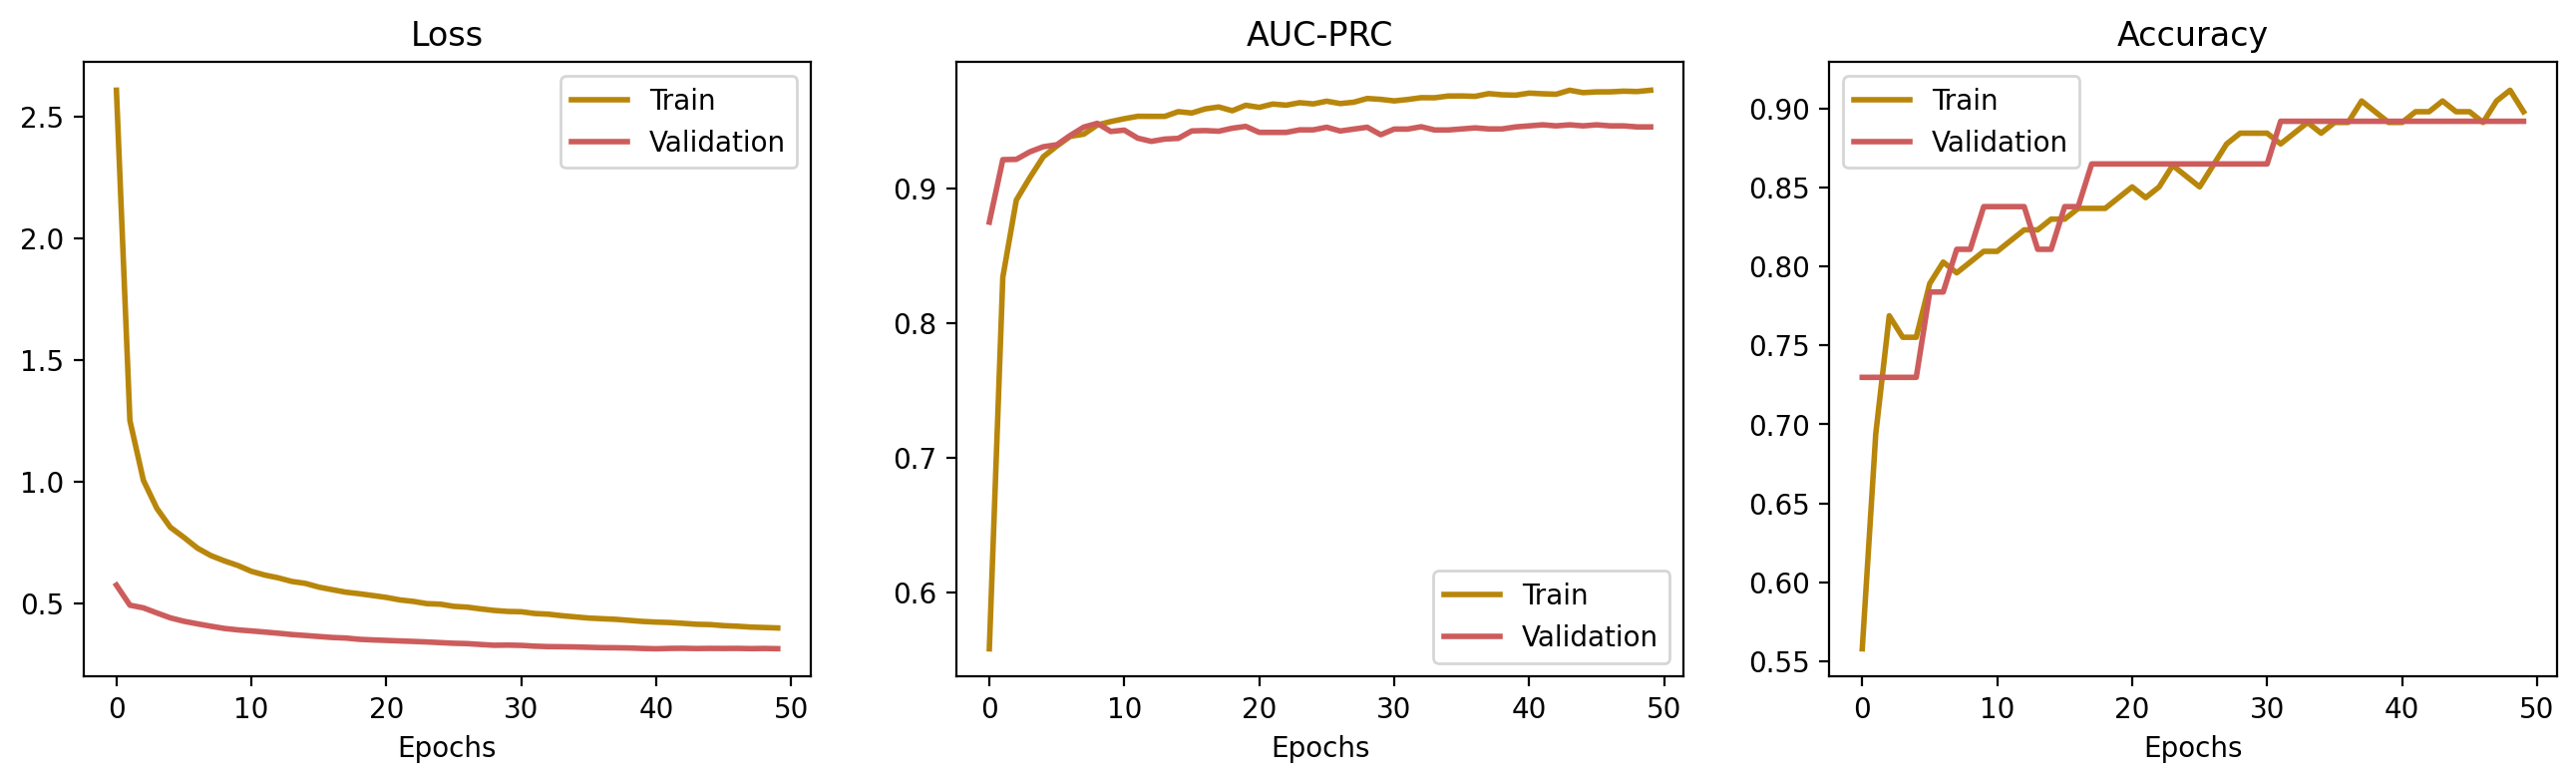


Baseline:          0.5000
Train Loss:           0.3991
Val Loss:           0.3138
Train Accuracy:     0.8980
Val Accuracy:     0.8919
AUC-PRC:           0.9733
Val AUC-PRC:           0.9460


In [156]:
# grab history
history = hist.history

# plot loss for train and validation
fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 3, 1)
plt.plot(history['loss'], lw=2, color='darkgoldenrod')
plt.plot(history['val_loss'], lw=2, color='indianred')
plt.legend(['Train', 'Validation'], fontsize=10)
ax.set_xlabel('Epochs', size=10)
ax.set_title('Loss');

# plot accuracy for train and validation
ax = fig.add_subplot(1, 3, 2)
plt.plot(history['prc'], lw=2, color='darkgoldenrod')
plt.plot(history['val_prc'], lw=2, color='indianred')
plt.legend(['Train', 'Validation'], fontsize=10)
ax.set_xlabel('Epochs', size=10)
ax.set_title('AUC-PRC');

# plot accuracy for train and validation
ax = fig.add_subplot(1, 3, 3)
plt.plot(history['accuracy'], lw=2, color='darkgoldenrod')
plt.plot(history['val_accuracy'], lw=2, color='indianred')
plt.legend(['Train', 'Validation'], fontsize=10)
ax.set_xlabel('Epochs', size=10)
ax.set_title('Accuracy');

plt.show()

print('\nBaseline:          %1.4f' %(np.count_nonzero(y_train == 0)/len(y_train)))
print('Train Loss:           %1.4f' %(history['loss'][-1]))
print('Val Loss:           %1.4f' %(history['val_loss'][-1]))
print('Train Accuracy:     %1.4f' %(history['accuracy'][-1]))
print('Val Accuracy:     %1.4f' %(history['val_accuracy'][-1]))
print('AUC-PRC:           %1.4f' %(history['prc'][-1]))
print('Val AUC-PRC:           %1.4f' %(history['val_prc'][-1]))

### Test the model

In [157]:
model_eval = model.evaluate(x=X_test, y=y_test,
                                verbose=0, return_dict=True)

y_test_pred = model.predict(x=X_test, verbose=0)

print('\nBaseline:          %1.4f' %(np.count_nonzero(y_test == 0)/len(y_test)))
print('Test Loss:     %1.4f' %(model_eval['loss']))
print('Test Accuracy:     %1.4f' %(model_eval['accuracy']))
print('\nAUC-PRC:           %1.4f' %(model_eval['prc']))
print('Balanced Log Loss: %1.4f' %(balanced_log_loss(y_test, y_test_pred)))


Baseline:          0.8710
Test Loss:     1.7896
Test Accuracy:     0.5484

AUC-PRC:           0.5712
Balanced Log Loss: -0.0766


**Conclusion:** Not great performance on the test set...